# Test Notebook for nisarcryodb applied to Solid Earth
---

This note book is used to develop, test, and document the  `nisarcryodb` class, which was developed to query the NISAR cal/val db for GPS data for the cryosphere validation sites.

This notebook demonstrates the same code can be used to access the solid earth GPS results.

Note the methods are all designed to **rollback** the database connection when errors arise. The errors are also trapped and presented more succinctly than typical python error messages. 


In [21]:
%load_ext autoreload
%autoreload 2
import nisarcryodb
from psycopg2 import sql
import matplotlib.pyplot as plt
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Initialize nisarcryodb Object

This step initializes the connection to the nisar cal/val data base. It requires a cal/val database user name and passwd.

In [22]:
myConnection = nisarcryodb.nisarcryodb()

User name:  irj
Password:  ········


## List Schema

List all of the schema in the database. 

In [23]:
schemas = myConnection.listSchema(quiet=False)

pg_catalog
information_schema
soil_moisture
pg_temp_7
pg_toast_temp_7
pg_temp_8
pg_toast_temp_8
disturbance
corner_reflectors
landice
solidearth
crop_area
inundation
pg_temp_16
pg_toast_temp_16
biomass
seaice
nisar
permafrost
tiger
tiger_data
topology
public


In [24]:
myConnection.listTableColumns('solidearth', 'interferogram');

interferogram_id, site_id, track_frame_id, obs_mode, polarization, bandwidth_pri, bandwidth_sec, product_type, product_path, creator, ref_date, repeat_date, isce_version, producer, config_file_path, date_created, granule_name, cycles_apart, band, input_type, archived


In [25]:
myConnection.getTableListing(schemaName='solidearth', tableName='interferogram')

SELECT * FROM solidearth.interferogram ;


,interferogram_id,site_id,track_frame_id,obs_mode,polarization,bandwidth_pri,bandwidth_sec,product_type,product_path,creator,...,repeat_date,isce_version,producer,config_file_path,date_created,granule_name,cycles_apart,band,input_type,archived
0,1,None,L001_F001_AF,None,HH,20,20,GUNW,test,user1,...,2024-01-01 00:00:00+00:00,0.18,custom,test,2024-06-01 00:00:00+00:00,test,10,L,ALOS,ready


## List Table Names for Schema

List the names of the table under the solidearth schema.

In [26]:
myConnection.listSchemaTableNames('solidearth');

validation_run_intf
validation_run_station
validation_run
interferogram
gps_version
gps_station
test_site_table
gps_measurement
l3_product
site


## List Column Names for Table

List the column names for a table (e.g., gps_station) and schema (e.g., landice).

In [27]:
stationColumns = myConnection.listTableColumns('solidearth', 'gps_station', quiet=False)

station_id, site_id, station_name, reflat, reflon, east_0, north_0, up_0, refframe, refheight, station_geom


This time get the columns for the `gps_measurement` table. Use `returnType=True` to get the data type for each column.

In [28]:
gpsColumns, gpsDataTypes = myConnection.listTableColumns('solidearth', 'gps_measurement', returnType=True)

measurement_id, station_id, gps_version_id, measurement_dt, decimal_year, east, north, up, ant, sig_e, sig_n, sig_u, corr_en, corr_eu, corr_nu
integer, integer, integer, date, double precision, double precision, double precision, double precision, double precision, double precision, double precision, double precision, double precision, double precision, double precision


## List Column Values

Get the `station_name` column values for `solidearth.gps_station` tables 

In [29]:
stationNames = myConnection.getColumn('solidearth', 'gps_station', 'station_name')
stationNames[0:10]

['01NA',
 '02NA',
 '0ABI',
 '0ABN',
 '0ABY',
 '0AKE',
 '0ALE',
 '0ALF',
 '0ALI',
 '0ALM']

Get the `latitude` and `longitude` column values for `solidearth.gps_station` tables 

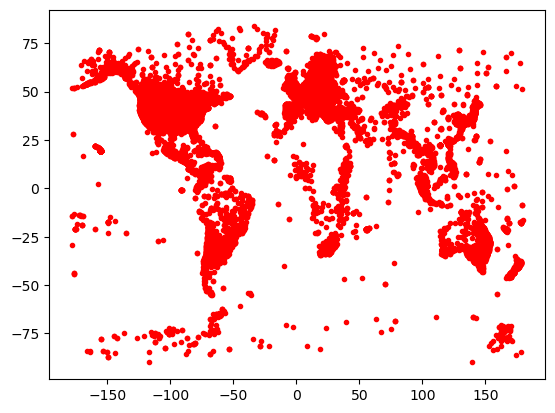

In [30]:
lat = myConnection.getColumn('solidearth', 'gps_station', 'reflat')
lon = myConnection.getColumn('solidearth', 'gps_station', 'reflon')
plt.plot(lon, lat, 'r.')

## Get Station and Site Information Tables

This section demonstrates how to return tables, with some basic filtering examples. The filtering is fairly basic, but since tables are return as pandas data frames, additional filtering can be applied via pandas operations. Return the table with all of the top-level station data (e.g,, name, id, position, etc).

In [31]:
table = myConnection.getTableListing(schemaName='solidearth', tableName='gps_station')
table

SELECT * FROM solidearth.gps_station ;


,station_id,site_id,station_name,reflat,reflon,east_0,north_0,up_0,refframe,refheight,station_geom
0,4290,NaN,01NA,-12.478,130.982,-1951.0,-1379987.0,105.0,None,105.409,0101000020E61000008195438B6C5F6040DBF97E6ABCF4...
1,10605,NaN,02NA,-12.356,130.882,-1987.0,-1366458.0,117.0,None,117.652,0101000020E61000004E621058395C604083C0CAA145B6...
2,8173,NaN,0ABI,68.354,18.816,677.0,7585405.0,431.0,None,431.388,0101000020E610000037894160E5D032402DB29DEFA716...
3,9822,NaN,0ABN,65.034,21.333,1548.0,7215094.0,52.0,None,52.762,0101000020E61000006891ED7C3F5535401904560E2D42...
4,9848,NaN,0ABY,58.659,16.180,-1181.0,6504674.0,60.0,None,60.548,0101000020E6100000AE47E17A142E30403108AC1C5A54...
...,...,...,...,...,...,...,...,...,...,...,...
22038,4169,NaN,ZWO2,52.503,6.093,-450.0,5819290.0,65.0,None,65.610,0101000020E6100000AC1C5A643B5F1840AAF1D24D6240...
22039,22005,NaN,ZWOL,52.502,6.096,-301.0,5819243.0,86.0,None,86.657,0101000020E6100000FCA9F1D24D621840C74B37894140...
22040,8624,NaN,ZYRA,52.055,20.420,1391.0,5769437.0,157.0,None,157.400,0101000020E6100000EC51B81E856B3440D7A3703D0A07...
22041,21765,NaN,ZYWE,49.688,19.197,-190.0,5506161.0,405.0,None,405.901,0101000020E6100000DF4F8D976E323340F2D24D6210D8...


The site data table is retrieved as:

In [32]:
myConnection.getTableListing(schemaName='solidearth', tableName='site')

SELECT * FROM solidearth.site ;


,site_id,site_name,date_start,date_end,seasonal,bbox_latmin,bbox_latmax,bbox_lonmin,bbox_lonmax,geom,...,rationale,prev_data,prev_study,science_product,science_method,validation_product,validation_method,tier,external_refs,notes
0,5,centralvalley,2001-01-01,None,True,34.9,36.9,-120.8,-119.0,0106000020E61000000100000001030000000100000005...,...,Subsidence from groundwater depletion,None,None,None,None,None,None,None,None,None
1,6,losangeles,2001-01-01,None,True,33.4,34.5,-119.0,-117.4,0106000020E61000000100000001030000000100000005...,...,None,None,None,None,None,None,None,None,None,None
2,7,mojave,2001-01-01,None,True,34.5,35.7,-116.5,-114.2,0106000020E61000000100000001030000000100000005...,...,Bounded by the San Andreas and Garlock fault z...,None,None,None,None,None,None,None,None,None
3,8,longvalley,2001-01-01,None,True,37.1,38.2,-119.5,-118.1,0106000020E61000000100000001030000000100000005...,...,"Thermal activity, seismicity, and deformation ...",None,None,None,None,None,None,None,None,None
4,9,mejillones,2001-01-01,None,True,-24.0,-22.0,-70.7,-67.0,0106000020E61000000100000001030000000100000005...,...,Uplift and faults,None,None,None,None,None,None,None,None,None
5,10,westoregon,2001-01-01,None,True,43.5,45.5,-124.4,-121.5,0106000020E61000000100000001030000000100000005...,...,Subduction zone,None,None,None,None,None,None,None,None,None
6,11,hokkaido,2001-01-01,None,True,41.8,44.4,139.8,143.3,0106000020E61000000100000001030000000100000005...,...,None,None,None,None,None,None,None,None,None,None
7,12,houston,2001-01-01,None,True,28.5,31.0,-97.3,-93.5,0106000020E61000000100000001030000000100000005...,...,Land subsidence,None,None,None,None,None,None,None,None,None
8,13,hawaii,2001-01-01,None,True,18.9,20.3,-156.2,-154.7,0106000020E61000000100000001030000000100000005...,...,Volcanism,None,None,None,None,None,None,None,None,None
9,14,newzealand,2001-01-01,None,True,-40.6,-37.0,173.6,176.2,0106000020E61000000100000001030000000100000005...,...,Tectonically active,None,None,None,None,None,None,None,None,None


To filter the sites for matches to a column(s), call with filters dict. In this example, the `%Humid%` indicates a wild card, so any value from the **climate** colum with the substring `Humid` will be selected.

In [33]:
myConnection.getTableListing(schemaName='solidearth', tableName='site', filters={'climate': '%Humid%'})

climate
SELECT * FROM solidearth.site  WHERE climate LIKE %(climate)s;


,site_id,site_name,date_start,date_end,seasonal,bbox_latmin,bbox_latmax,bbox_lonmin,bbox_lonmax,geom,...,rationale,prev_data,prev_study,science_product,science_method,validation_product,validation_method,tier,external_refs,notes
0,11,hokkaido,2001-01-01,None,True,41.8,44.4,139.8,143.3,0106000020E61000000100000001030000000100000005...,...,None,None,None,None,None,None,None,None,None,None
1,12,houston,2001-01-01,None,True,28.5,31.0,-97.3,-93.5,0106000020E61000000100000001030000000100000005...,...,Land subsidence,None,None,None,None,None,None,None,None,None


Similarly, to select sites with **category** `Desert` and **climate** `hot`, the query would be:

In [34]:
myConnection.getTableListing(schemaName='solidearth', tableName='site', filters={'category': '%Desert%', 'climate': '%Hot%'})

category
climate
SELECT * FROM solidearth.site  WHERE category LIKE %(category)s AND climate LIKE %(climate)s;


,site_id,site_name,date_start,date_end,seasonal,bbox_latmin,bbox_latmax,bbox_lonmin,bbox_lonmax,geom,...,rationale,prev_data,prev_study,science_product,science_method,validation_product,validation_method,tier,external_refs,notes
0,5,centralvalley,2001-01-01,None,True,34.9,36.9,-120.8,-119.0,0106000020E61000000100000001030000000100000005...,...,Subsidence from groundwater depletion,None,None,None,None,None,None,None,None,None
1,6,losangeles,2001-01-01,None,True,33.4,34.5,-119.0,-117.4,0106000020E61000000100000001030000000100000005...,...,None,None,None,None,None,None,None,None,None,None
2,7,mojave,2001-01-01,None,True,34.5,35.7,-116.5,-114.2,0106000020E61000000100000001030000000100000005...,...,Bounded by the San Andreas and Garlock fault z...,None,None,None,None,None,None,None,None,None


In [35]:
myConnection.getTableListing(schemaName='solidearth', tableName='interferogram')

SELECT * FROM solidearth.interferogram ;


,interferogram_id,site_id,track_frame_id,obs_mode,polarization,bandwidth_pri,bandwidth_sec,product_type,product_path,creator,...,repeat_date,isce_version,producer,config_file_path,date_created,granule_name,cycles_apart,band,input_type,archived
0,1,None,L001_F001_AF,None,HH,20,20,GUNW,test,user1,...,2024-01-01 00:00:00+00:00,0.18,custom,test,2024-06-01 00:00:00+00:00,test,10,L,ALOS,ready


## Station Name to ID

Determine the station ID (e.g., 16156) from the station name (e.g., LIZY). This translation is needed to map the station name to station id needed to index the table above.

In [36]:
myConnection.stationNameToID('LIZY', schemaName='solidearth')

16516

## Get GPS Data for Date Range

Return all the data for a designated station for the decimal date range (d1, d2). This next cell could take a minute or more to query the DB. 

In [37]:
%%time
d1 = 2019
d2 = 2024
myData = myConnection.getStationDateRangeData('LIZY', d1, d2, 'solidearth', 'gps_measurement')
myData

CPU times: user 7.77 ms, sys: 1.62 ms, total: 9.39 ms
Wall time: 1min 30s


,measurement_id,station_id,gps_version_id,measurement_dt,decimal_year,east,north,up,ant,sig_e,sig_n,sig_u,corr_en,corr_eu,corr_nu
0,32426977,16516,1,2019-10-16,2019.7892,0.284055,1.051965,0.168401,0.0,0.000826,0.001137,0.003475,0.035921,-0.027373,-0.054672
1,32426694,16516,1,2019-01-01,2019.0007,0.268310,1.041053,0.163901,0.0,0.000729,0.001010,0.003054,0.027100,-0.007433,0.008353
2,32426695,16516,1,2019-01-02,2019.0034,0.268359,1.039897,0.161507,0.0,0.000752,0.001039,0.003136,0.001439,0.011485,0.012033
3,32426696,16516,1,2019-01-03,2019.0062,0.269582,1.040483,0.159832,0.0,0.000819,0.001158,0.003330,0.006994,0.026640,-0.002563
4,32426697,16516,1,2019-01-04,2019.0089,0.269202,1.040916,0.163606,0.0,0.000719,0.000996,0.002984,0.031598,0.002110,-0.017285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037,32426972,16516,1,2019-10-11,2019.7755,0.285619,1.054549,0.171184,0.0,0.000806,0.001095,0.003332,0.010983,-0.020648,-0.004829
1038,32426973,16516,1,2019-10-12,2019.7782,0.284397,1.052664,0.175129,0.0,0.000757,0.001024,0.003154,0.013865,0.036426,-0.065382
1039,32426974,16516,1,2019-10-13,2019.7810,0.283185,1.053322,0.181223,0.0,0.000773,0.001047,0.003216,0.026080,0.008626,-0.040586
1040,32426975,16516,1,2019-10-14,2019.7837,0.283162,1.053376,0.175483,0.0,0.000812,0.001081,0.003407,0.036229,0.015138,-0.053068


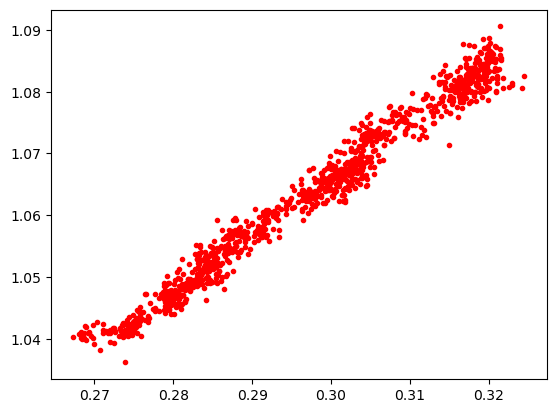

In [38]:
plt.plot(myData['east'], myData['north'], 'r.')

## Rollback a Query Error

This will reset the connection after a query fails with an error. Most of the routines should trap errors and automatically rollback.

In [39]:
myConnection.connection.rollback()

## Close the connection

Close the connection when finished.

In [40]:
myConnection.close()